1. IMPORTING REQUIRED LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# For ARIMA/SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler



 2. DATA COLLECTION & DATA PREPROCESSING

In [2]:


# Read raw TCS stock data
df = pd.read_csv('tcs_stock.csv')

# Initial validation
print("Data Head:\n", df.head())
print("Info:")
df.info()
print("Description:\n", df.describe())

# Remove duplicate records
df = df.drop_duplicates()

# Check for missing/null values
print("Null values per column:\n", df.isnull().sum())

# Rename columns for consistency
df.rename(columns=lambda name: name.strip().title().replace(' ', '_'), inplace=True)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Remove records with zero volume
df = df[df['Volume'] > 0].reset_index(drop=True)

# Derive new features
df = df.sort_values('Date').reset_index(drop=True)
df['Price_Change'] = df['Close'] - df['Open']
df['Percentage_Change'] = df['Price_Change'] / df['Open'] * 100
df['Daily_Return'] = df['Close'].pct_change()

# Save cleaned data
df.to_csv('tcs_stock_cleaned.csv', index=False)

# For further steps, reload the cleaned data
df = pd.read_csv('tcs_stock_cleaned.csv')
df['Date'] = pd.to_datetime(df['Date'])


Data Head:
          Date Symbol Series  Prev Close    Open     High      Low     Last  \
0  2015-01-01    TCS     EQ     2558.25  2567.0  2567.00  2541.00  2550.00   
1  2015-01-02    TCS     EQ     2545.55  2551.0  2590.95  2550.60  2588.40   
2  2015-01-05    TCS     EQ     2579.45  2581.0  2599.90  2524.65  2538.10   
3  2015-01-06    TCS     EQ     2540.25  2529.1  2529.10  2440.00  2450.05   
4  2015-01-07    TCS     EQ     2446.60  2470.0  2479.15  2407.45  2426.90   

     Close     VWAP   Volume      Turnover  Trades  Deliverable Volume  \
0  2545.55  2548.51   183415  4.674345e+13    8002               52870   
1  2579.45  2568.19   462870  1.188740e+14   27585              309350   
2  2540.25  2563.94   877121  2.248886e+14   43234              456728   
3  2446.60  2466.90  1211892  2.989615e+14   84503              714306   
4  2417.70  2433.96  1318166  3.208362e+14  101741              886368   

   %Deliverble  
0       0.2883  
1       0.6683  
2       0.5207  
3     

3. EDA & VISUALIZATIONS

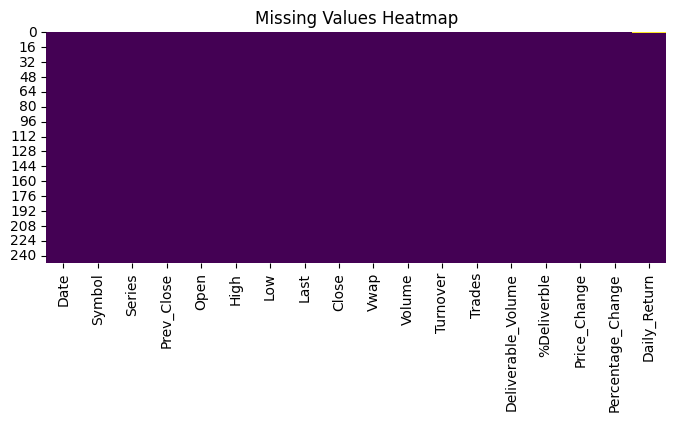

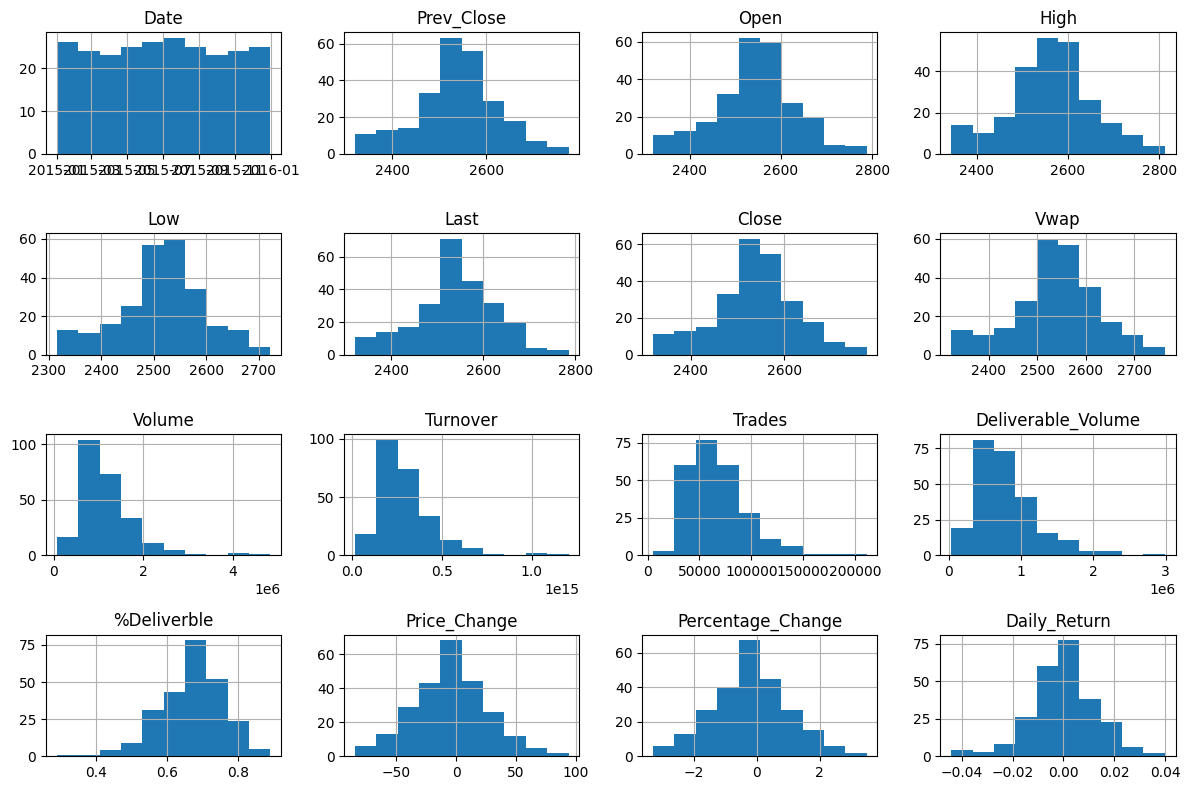

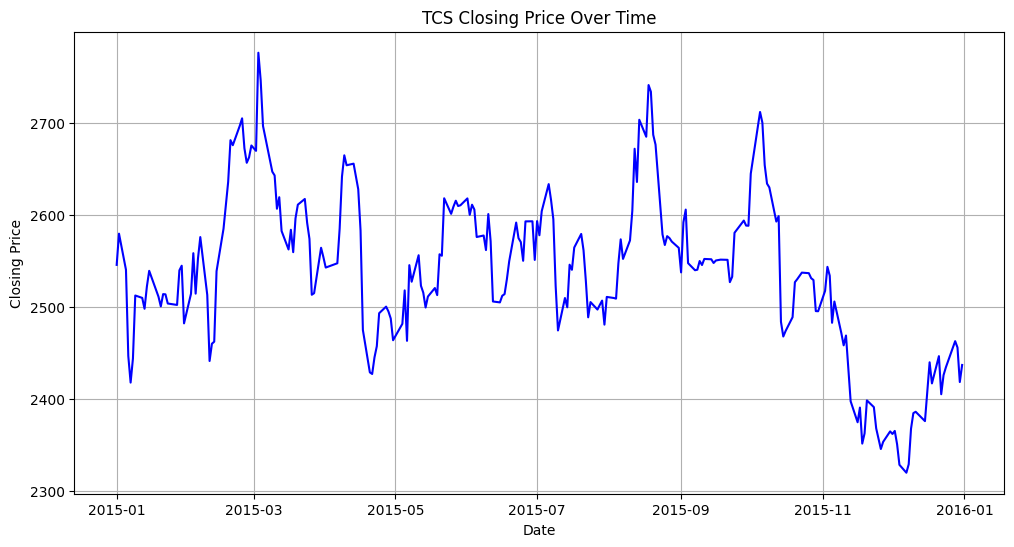

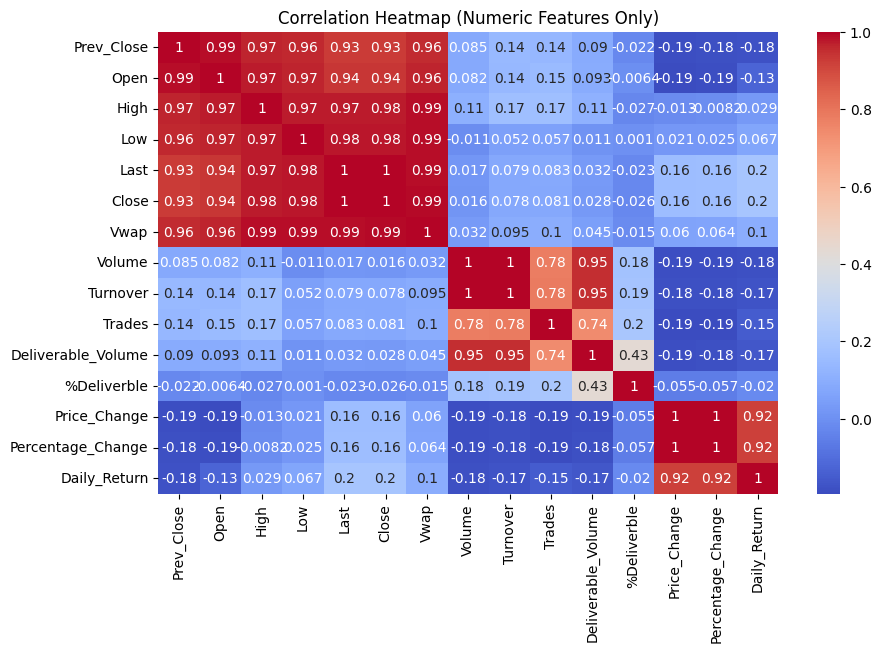

In [3]:
# Missing values heatmap
plt.figure(figsize=(8,3))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Distribution histograms (numeric features)
df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

# Closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title("TCS Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

# Correlation heatmap for numeric features
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


 4. TIME SERIES MODELING: ARIMA / SARIMA

c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  248
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1209.122
Date:                Wed, 29 Oct 2025   AIC                           2430.243
Time:                        08:40:14   BIC                           2451.300
Sample:                             0   HQIC                          2438.721
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0690      0.065      1.068      0.285      -0.058       0.196
ar.L2          0.0004      0.061      0.007      0.995      -0.119       0.120
ar.L3         -0.0585      0.

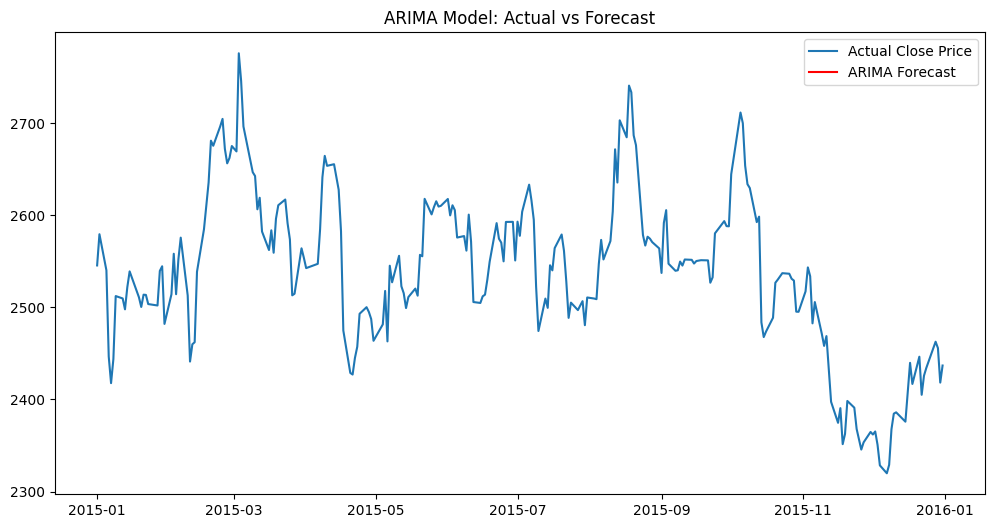

c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


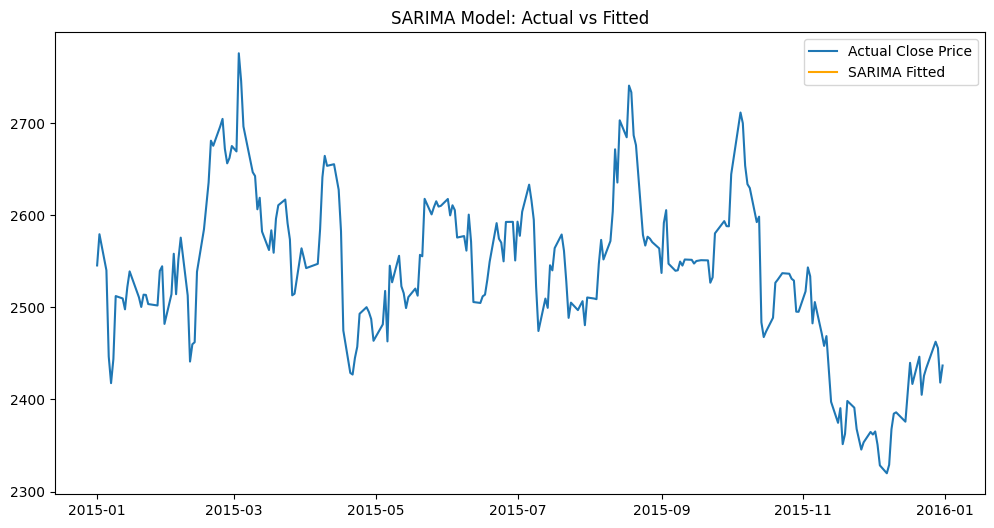

In [ ]:
# (Use only 'Close' price series with non-null values)
ts_data = df[['Date', 'Close']].set_index('Date')['Close']

arima_order = (5, 1, 0)  # Example order (p,d,q)
arima_model = ARIMA(ts_data, order=arima_order)
arima_fit = arima_model.fit()
print("\nARIMA Model Summary:\n", arima_fit.summary())

# In-sample prediction
df['ARIMA_Forecast'] = arima_fit.predict(start=arima_order[1], end=len(ts_data)-1, typ='levels')

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual Close Price')
plt.plot(df['Date'][arima_order[1]:], df['ARIMA_Forecast'][arima_order[1]:], color='red', label='ARIMA Forecast')
plt.title('ARIMA Model: Actual vs Forecast')
plt.legend()
plt.show()

#Sarima Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Example seasonal order (P,D,Q,s)
sarima_model = SARIMAX(ts_data, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
df['SARIMA_Fitted'] = sarima_fit.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Actual Close Price')
plt.plot(df['Date'], df['SARIMA_Fitted'], color='orange', label='SARIMA Fitted')
plt.title('SARIMA Model: Actual vs Fitted')
plt.legend()
plt.show()

5. DEEP LEARNING MODELING: LSTM

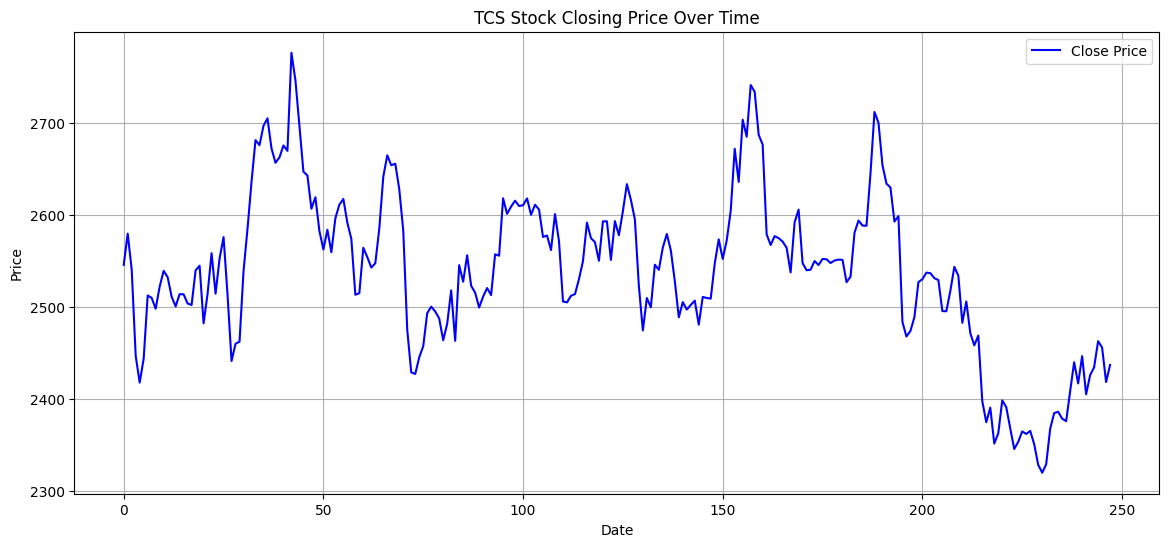

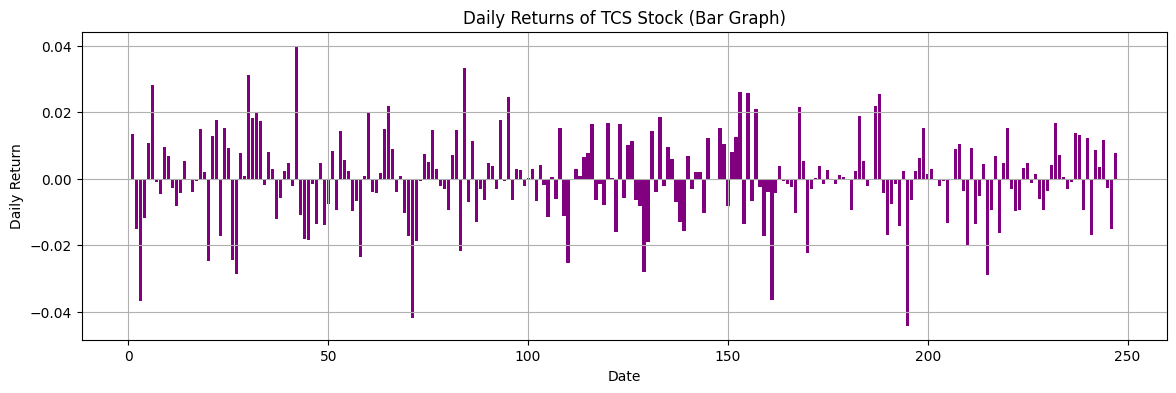

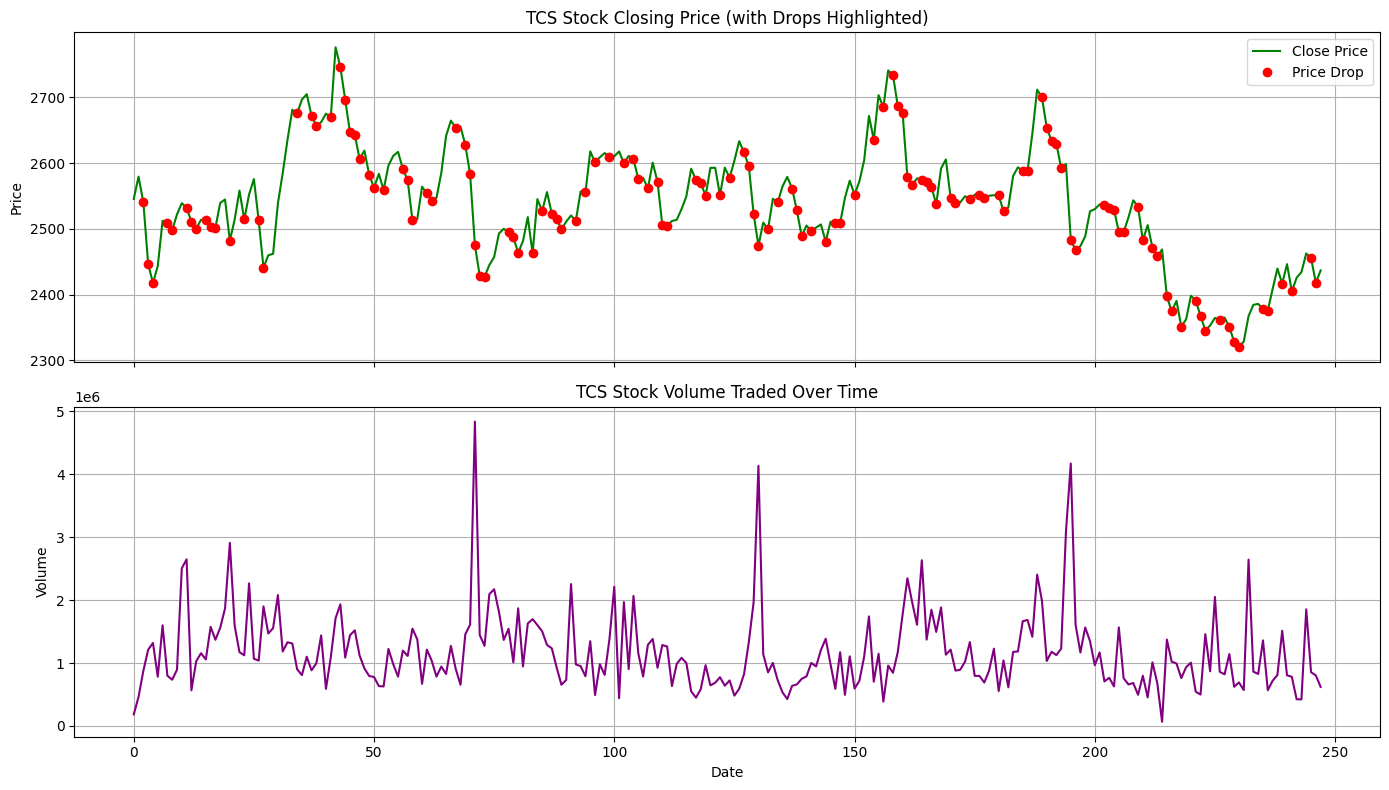

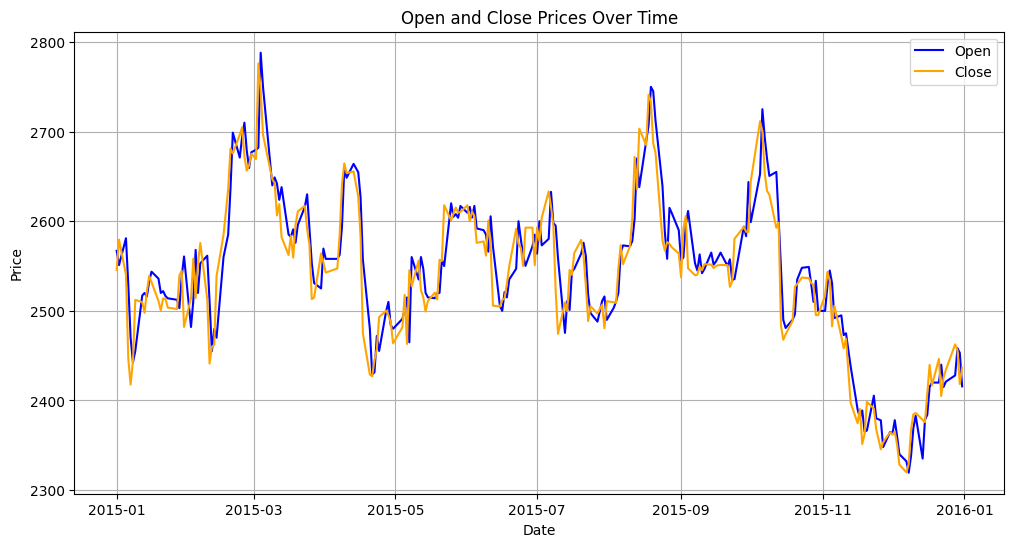

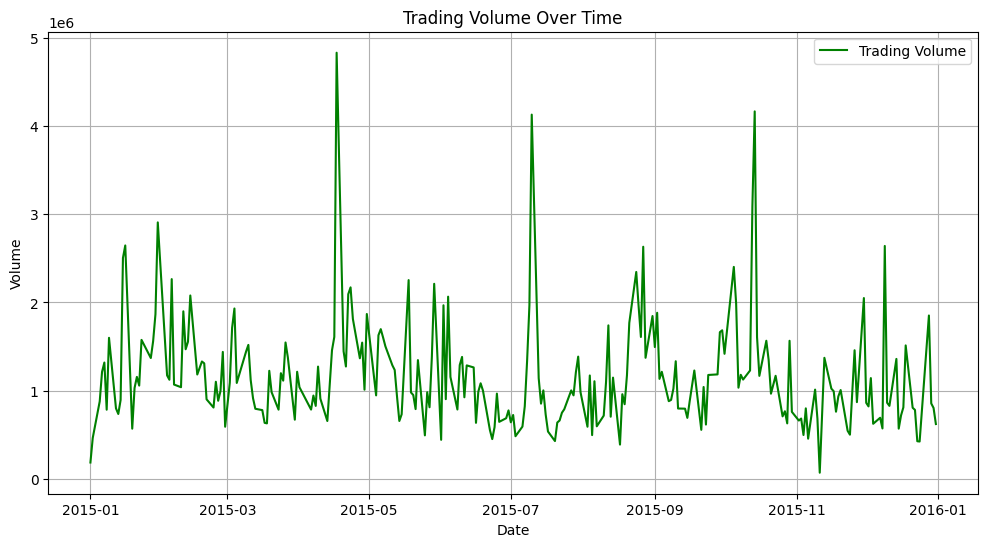

       Close
0    2545.55
1    2579.45
2    2540.25
3    2446.60
4    2417.70
..       ...
243  2434.25
244  2462.70
245  2455.80
246  2418.30
247  2436.85

[248 rows x 1 columns]
[[ 0.09014578]
 [ 0.48032964]
 [ 0.02914359]
 [-1.04875372]
 [-1.38138834]]
X shape: (188, 60)
y shape: (188,)
(188, 60, 1)

Train shape X: (178, 60, 1), y: (178,)
Test shape X: (10, 60, 1), y: (10,)
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.7353 - mae: 0.6513 - val_loss: 0.3645 - val_mae: 0.5717
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.7166 - mae: 0.6561 - val_loss: 0.6958 - val_mae: 0.8097
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.5316 - mae: 0.5678 - val_loss: 0.8528 - val_mae: 0.8950
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3868 - mae: 0.4724 - val_loss: 0.0743 - val_mae: 0.2257
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.3876 - mae: 0.4604 - val_loss: 0.1184 - val_mae: 0.2802
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/

In [5]:
#GRAPHS FOR REPRESENTATIONS FOR LSTM MODEL

#closing price over time
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('TCS Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate daily returns
df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(14, 4))
plt.bar(df.index, df['Daily Return'], color='purple')
plt.title('Daily Returns of TCS Stock (Bar Graph)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

##for volume vs price drop

# Calculate daily returns
df['Daily Return'] = df['Close'].pct_change()

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Closing Price with Drops Highlighted ---
ax1.plot(df.index, df['Close'], label='Close Price', color='green')
ax1.plot(df[df['Daily Return'] < 0].index, df[df['Daily Return'] < 0]['Close'],
         marker='o', linestyle='None', color='red', label='Price Drop')
ax1.set_title('TCS Stock Closing Price (with Drops Highlighted)')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# --- Volume Plot ---
ax2.plot(df.index, df['Volume'], label='Volume', color='purple')
ax2.set_title('TCS Stock Volume Traded Over Time')
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.grid(True)

plt.tight_layout()
plt.show()

#Graph of open & close

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='orange')
plt.title('Open and Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#Graph for Volume Trade

plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Volume'], color='green', label='Trading Volume')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


#LSTM MODEL IMPLEMENTATION

target_column = 'Close'
data = df[[target_column]]
print(data)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
print(scaled_data[:5])

#Creating Sequence of 60 days slide window

sequence_length = 60

X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

#LSTM Input format: [samples,time steps,features]

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print( X.shape)

#Training & Testing Sets

train_size = int(len(X) * 0.95)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nTrain shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Test shape X: {X_test.shape}, y: {y_test.shape}")

#LSTM layers Implementation

model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

#Compile The Model and Training The model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


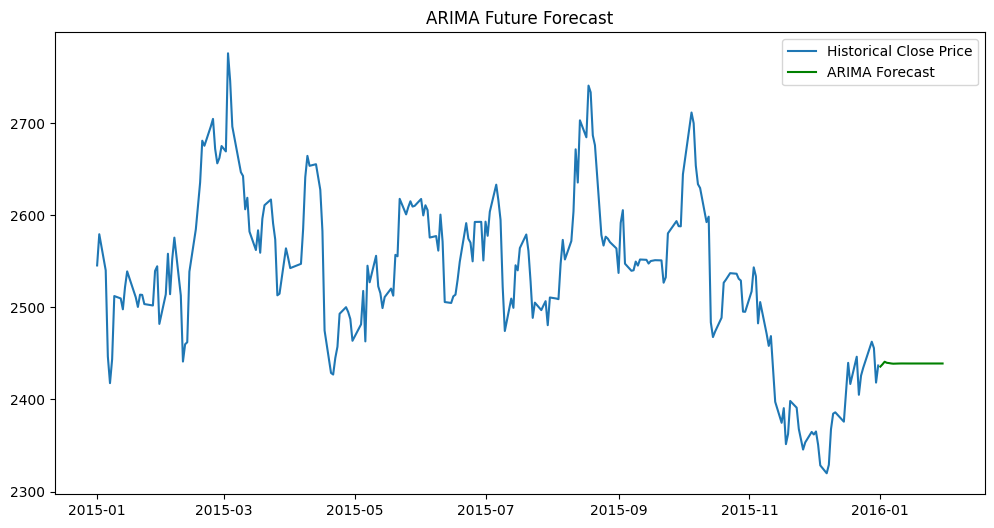

c:\Users\Riddhi shah\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


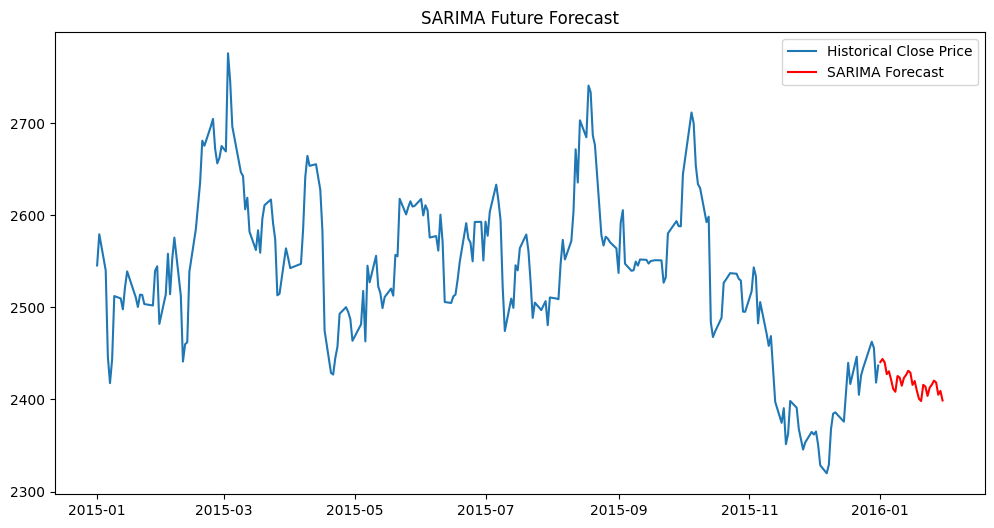

In [ ]:
#ARIMA FUTURE FORECASTING
# Forecast next 30 days 
future_steps = 30
future_forecast = arima_fit.forecast(steps=future_steps)

# Create future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_steps)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Historical Close Price')
plt.plot(future_dates, future_forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Future Forecast')
plt.legend()
plt.show()


# SARIMA FUTURE FORECASTING
future_steps = 30
forecast_sarima = sarima_fit.get_forecast(steps=future_steps)
future_forecast_sarima = forecast_sarima.predicted_mean

future_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=future_steps)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Historical Close Price')
plt.plot(future_dates, future_forecast_sarima, label='SARIMA Forecast', color='red')
plt.title('SARIMA Future Forecast')
plt.legend()
plt.show()

08:40:28 - cmdstanpy - INFO - Chain [1] start processing
08:40:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Performance:
MAE: 160.9505
RMSE: 174.7748


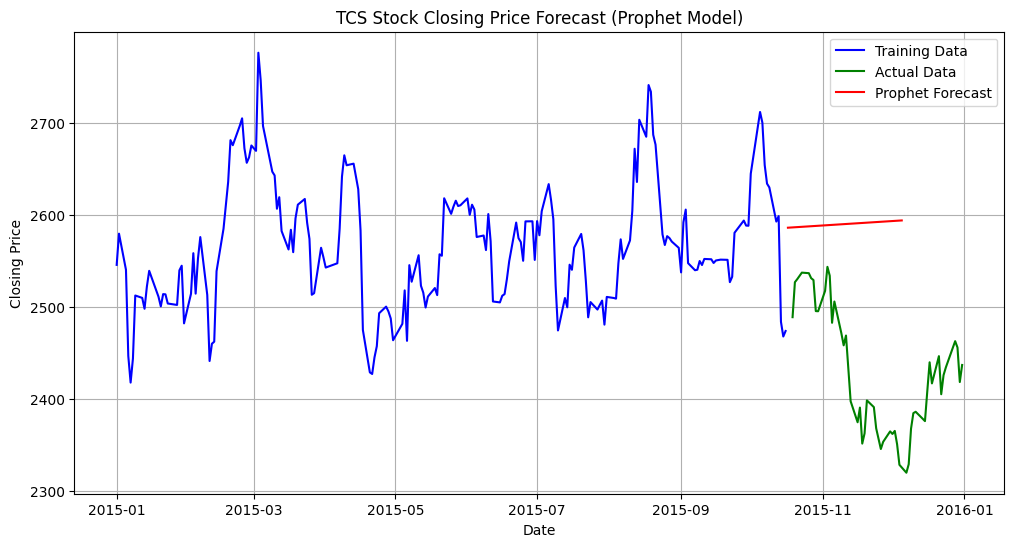

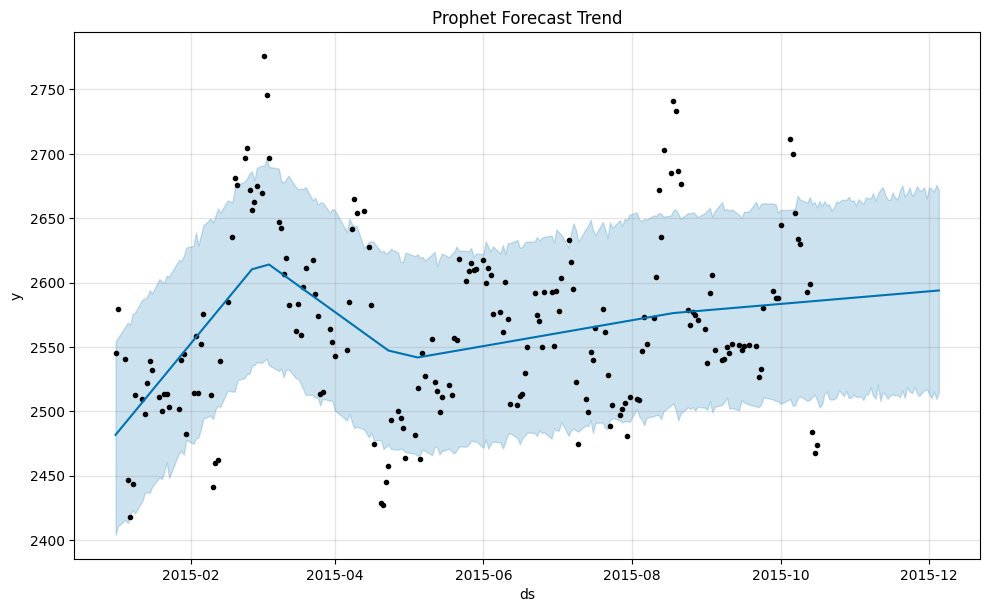

In [7]:
# PROPHET MODEL 

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare data 
prophet_df = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Train-test split 
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Initialize Prophet model 
prophet_model = Prophet(weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(train_df)

# Create future dataframe 
future = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = prophet_model.predict(future)

# Extract only test period predictions
predictions = forecast[['ds', 'yhat']].iloc[-len(test_df):]
actual = test_df['y'].values
predicted = predictions['yhat'].values

# EVALUATION 
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print("Prophet Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# VISUALIZATION 
plt.figure(figsize=(12,6))
plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Actual Data', color='green')
plt.plot(predictions['ds'], predictions['yhat'], label='Prophet Forecast', color='red')
plt.title('TCS Stock Closing Price Forecast (Prophet Model)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

# Prophet trend visualization 
prophet_model.plot(forecast)
plt.title("Prophet Forecast Trend")
plt.show()


# --- SAVE ALL TRAINED MODELS ---

import pickle
from prophet.serialize import model_to_json

# --- ARIMA Model ---
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_fit, f)
print("ARIMA model saved as arima_model.pkl")

# --- SARIMA Model ---
with open("sarima_model.pkl", "wb") as f:
    pickle.dump(sarima_fit, f)
print("SARIMA model saved as sarima_model.pkl")

# --- LSTM Model ---
model.save("lstm_model.h5")
print("LSTM model saved as lstm_model.h5")

# --- Prophet Model ---
with open("prophet_model.json", "w") as f:
    f.write(model_to_json(prophet_model))
print("Prophet model saved as prophet_model.json")
